# EY Data Science Challenge 2026
# Taller de imagenes satelitales 

In [3]:
import pandas as pd

# Visualizacion basica con pandas

Cargamos datos

In [4]:
training_df = pd.read_csv('water_quality_training_dataset.csv', usecols=['Latitude','Longitude'])
testing_df = pd.read_csv('submission_template.csv', usecols=['Latitude','Longitude'])
training_df = training_df.drop_duplicates()
testing_df = testing_df.drop_duplicates()

Revisamos algunas observaciones

In [5]:
training_df.head()

,Latitude,Longitude
0,-28.760833,17.730278
1,-26.861111,28.884722
2,-26.450000,28.085833
3,-27.671111,27.236944
4,-27.356667,27.286389


In [6]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162 entries, 0 to 6540
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   162 non-null    float64
 1   Longitude  162 non-null    float64
dtypes: float64(2)
memory usage: 3.8 KB


Intentemos visualizar los puntos

<Axes: >

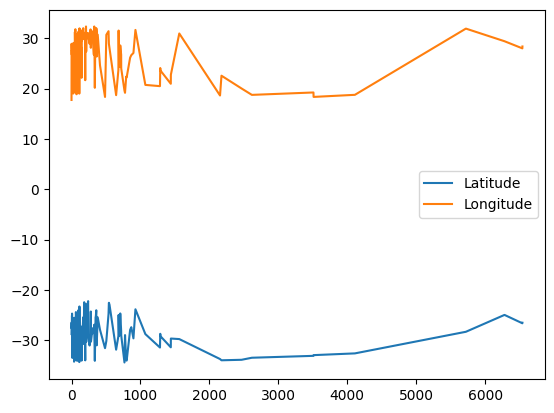

In [7]:
training_df.plot()

## Ahora agreguemos un mapa, usando geopandas

Geopandas es una extensión de pandas para analizar datos espaciales. Los dataframes espaciales, GeoDataFrame, contienen una columna especial llamada geometry que se utiliza para realizar operaciones espaciales comunes.

In [8]:
import geopandas as gpd

Creamos la columna geometry a partir de la latitud y longitud. 
Noten que el software geografico suele utilizar las coordenadas geograficas en el orden (Longitud, Latitud)

In [9]:
training_df = gpd.GeoDataFrame(training_df, geometry=gpd.points_from_xy(training_df.Longitude, training_df.Latitude), crs='EPSG:4326')

In [10]:
training_df.head()

,Latitude,Longitude,geometry
0,-28.760833,17.730278,POINT (17.73028 -28.76083)
1,-26.861111,28.884722,POINT (28.88472 -26.86111)
2,-26.450000,28.085833,POINT (28.08583 -26.45)
3,-27.671111,27.236944,POINT (27.23694 -27.67111)
4,-27.356667,27.286389,POINT (27.28639 -27.35667)


La columna geometry tiene data type 'geometry'. Es posible tener varias columnas de tipo geometry en un mismo dataframe, pero solo una columa se considera activa a la vez.

In [11]:
training_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 162 entries, 0 to 6540
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Latitude   162 non-null    float64 
 1   Longitude  162 non-null    float64 
 2   geometry   162 non-null    geometry
dtypes: float64(2), geometry(1)
memory usage: 5.1 KB


Usar el metodo plot con un GeoDataFrame automaticamente grafica la geometria activa

<Axes: >

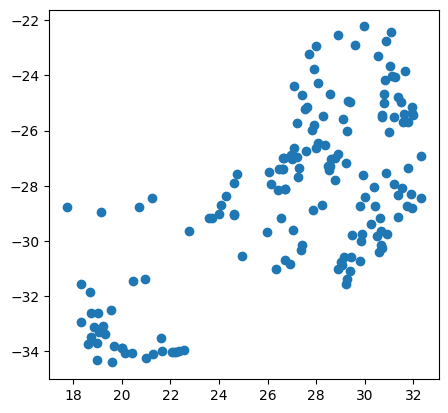

In [12]:
training_df.plot()

Utilicemos el modulo contextily para agregar un mapa de fondo. Contextily descarga mapas de distintos proveedores y los agrega automaticamente al gráfico.
Más información: https://contextily.readthedocs.io/en/latest/providers_deepdive.html

In [13]:
import contextily as cx

/home/aleksei/Documentos/python/water-quality/.venv/lib/python3.12/site-packages/contextily/tile.py:662: UserWarning: The inferred zoom level of 23 is not valid for the current tile provider (valid zooms: 0 - 17).
  warnings.warn(msg)


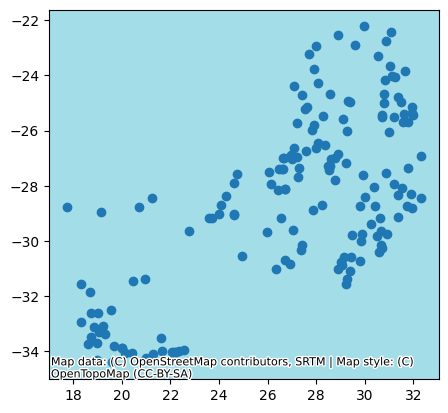

In [14]:
axis = training_df.plot()
cx.add_basemap(ax=axis, source=cx.providers.OpenTopoMap)

El mapa falla porque le falta una pieza de información esencial: el crs.



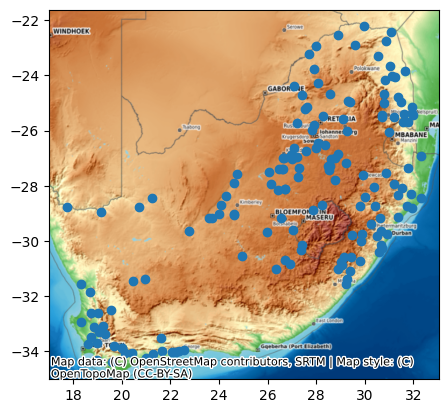

In [15]:
axis = training_df.plot()
cx.add_basemap(ax=axis, source=cx.providers.OpenTopoMap, crs = training_df.crs)

# Operaciones espaciales: Encontrando el rio de cada observacion

Utilizaremos información entregada por el gobierno de sudafrica acerca de los rios en ese pais, para determinar en que río fue realizada cada observación.
Fuente de los datos: https://www.dws.gov.za/iwqs/gis_data/river/rivs500k.aspx

In [16]:
rivers_df = gpd.read_file("All/wriall500.shp")[['NAME','geometry','DIST2MTH']]
rivers_df.head(3)

,NAME,geometry,DIST2MTH
0,Rooisloot,"LINESTRING (29.16403 -24.22761, 29.16404 -24.2...",20464.421
1,Mphongolo,"LINESTRING (31.38792 -23.04376, 31.38901 -23.0...",563146.285
2,Little Letaba,"LINESTRING (31.01652 -23.48696, 31.01811 -23.4...",564385.928


In [17]:
training_df.sjoin(rivers_df, how='inner', predicate='within')

/home/aleksei/Documentos/python/water-quality/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:2560: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(


,Latitude,Longitude,geometry,index_right,NAME,DIST2MTH


La operación nuevamente falla por los crs...

Un CRS (coordinate reference system) contiene la información esencial para realizar operaciones espaciales: un sistema de coordenadas.
Los CRS contienen un modelo del planeta, una definición del sistema de coordenadas y una unidad de medida. Para que una operación espacial tenga sentido, todos los datos sobre lo que operamos tienen que tener el mismo CRS.

In [18]:
training_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Agregamos un crs al df de rivers

In [19]:
rivers_df = rivers_df.set_crs(epsg=4326)
rivers_df

,NAME,geometry,DIST2MTH
0,Rooisloot,"LINESTRING (29.16403 -24.22761, 29.16404 -24.2...",20464.421
1,Mphongolo,"LINESTRING (31.38792 -23.04376, 31.38901 -23.0...",563146.285
2,Little Letaba,"LINESTRING (31.01652 -23.48696, 31.01811 -23.4...",564385.928
3,Little Letaba,"LINESTRING (31.12426 -23.56749, 31.12519 -23.5...",541565.516
4,Little Letaba,"LINESTRING (31.10138 -23.59351, 31.10197 -23.5...",537096.182
...,...,...,...
10347,Kaaloog se Loop,"LINESTRING (26.35062 -25.78882, 26.35653 -25.7...",1670711.418
10348,Ribbokfontein se Loop,"LINESTRING (26.66339 -25.84109, 26.66213 -25.8...",1690024.317
10349,Ribbokfontein se Loop,"LINESTRING (26.45072 -25.78152, 26.4502 -25.78...",1661300.195
10350,Bokkraal se Loop,"LINESTRING (26.47448 -25.83631, 26.47283 -25.8...",1668691.480


Podemos usar el metodo sjoin (Spatial Join) para realizar joins estilo SQL, pero cuyos predicados son relaciones espaciales.

In [20]:
training_df.sjoin(rivers_df, how='inner', predicate='within')

,Latitude,Longitude,geometry,index_right,NAME,DIST2MTH


Los predicados espaciales son muy estrictos. Como ninguna observación cae exactamente sobre la geometría del río, el resultado es un dataframe vacío.
Por suerte geopandas tiene una función de conveniencia que es mucho menos estricta.

In [21]:
training_df.sjoin(rivers_df, how='inner', predicate='dwithin', distance = 100)

,Latitude,Longitude,geometry,index_right,NAME,DIST2MTH
0,-28.760833,17.730278,POINT (17.73028 -28.76083),5132,None,41110.825
0,-28.760833,17.730278,POINT (17.73028 -28.76083),5148,Heuningnes,29391.243
0,-28.760833,17.730278,POINT (17.73028 -28.76083),5142,Heuningnes,15505.523
0,-28.760833,17.730278,POINT (17.73028 -28.76083),5130,Ratel,22743.597
0,-28.760833,17.730278,POINT (17.73028 -28.76083),5139,Nuwejaar,40369.922
...,...,...,...,...,...,...
6540,-26.510278,28.351389,POINT (28.35139 -26.51028),9904,None,1094232.236
6540,-26.510278,28.351389,POINT (28.35139 -26.51028),9509,None,1072641.545
6540,-26.510278,28.351389,POINT (28.35139 -26.51028),9510,None,1079630.270
6540,-26.510278,28.351389,POINT (28.35139 -26.51028),9903,None,1097975.615


Obtenemos que todas las observaciones fueron hechas en todos los ríos!
El CRS que estamos utilizando es un CRS geográfico que engloba toda el planeta, y cuya unidad de medida son los grados.

Para trabajar con metros, necesitamos un CRS proyectado cuya unidad sea el metro. Podemos buscar CRS en la siguiente página web: https://epsg.io/
Para sudafrica, podemos utilizar el EPSG:9221

In [22]:
training_df = training_df.to_crs(epsg=9221)
rivers_df = rivers_df.to_crs(epsg=9221)

In [23]:
training_df.sjoin(rivers_df, how='inner', predicate='dwithin', distance = 500)

,Latitude,Longitude,geometry,index_right,NAME,DIST2MTH
0,-28.760833,17.730278,POINT (697102.389 1416584.505),2468,Orange,306925.379
1,-26.861111,28.884722,POINT (1782913.129 1644616.173),1052,Waterval,2274612.369
2,-26.450000,28.085833,POINT (1705412.696 1692877.066),1147,Klip,2117136.485
2,-26.450000,28.085833,POINT (1705412.696 1692877.066),1693,Rietspruit,2129380.110
2,-26.450000,28.085833,POINT (1705412.696 1692877.066),978,Klip,2182397.251
...,...,...,...,...,...,...
4110,-32.601389,18.750556,POINT (818854.032 993120.781),5169,Bergvallei,82886.244
5720,-28.308889,31.902500,POINT (2070448.865 1469222.778),8618,Black Mfolozi,129513.212
6280,-24.958611,29.395278,POINT (1841275.182 1854884.507),23,Olifants,900128.407
6539,-26.619444,27.980833,POINT (1694535.604 1674238.23),1159,Klip,2085677.560


En vez de ajustar la distancia hasta encontrar el valor exacto, geopandas tiene la funcion de conveniencia sjoin_nearest que automaticamente elige el río mas cercano.

In [24]:
training_df = training_df.sjoin_nearest(rivers_df, how='inner', distance_col='distance')
training_df

,Latitude,Longitude,geometry,index_right,NAME,DIST2MTH,distance
0,-28.760833,17.730278,POINT (697102.389 1416584.505),2468,Orange,306925.379,20.592370
1,-26.861111,28.884722,POINT (1782913.129 1644616.173),1052,Waterval,2274612.369,6.771998
2,-26.450000,28.085833,POINT (1705412.696 1692877.066),1147,Klip,2117136.485,72.592359
3,-27.671111,27.236944,POINT (1618771.304 1558423.589),1301,Vals,1933271.818,65.123016
4,-27.356667,27.286389,POINT (1624300.789 1593465.933),1543,Heuningspruit,1984894.978,95.199411
...,...,...,...,...,...,...,...
4110,-32.601389,18.750556,POINT (818854.032 993120.781),5159,Kruismans,65470.313,2.260292
5720,-28.308889,31.902500,POINT (2070448.865 1469222.778),8618,Black Mfolozi,129513.212,10.369677
6280,-24.958611,29.395278,POINT (1841275.182 1854884.507),23,Olifants,900128.407,99.586276
6539,-26.619444,27.980833,POINT (1694535.604 1674238.23),1159,Klip,2085677.560,31.189882


¿Que tan cerca estan los puntos de observación del rio asignado?

In [25]:
training_df.sort_values(by='distance', ascending=False)

,Latitude,Longitude,geometry,index_right,NAME,DIST2MTH,distance
153,-29.987778,29.851667,POINT (1863515.204 1291648.534),7558,Mzimkhulu,248591.162,8453.619728
1441,-29.651389,22.746389,POINT (1183913.264 1336915.197),2912,Orange,1048440.848,481.075516
338,-34.075556,20.145556,POINT (955405.153 834630.959),5448,Riviersonderend,142561.172,290.966847
51,-31.554722,29.245556,POINT (1799201.918 1118635.11),7907,Mngazi,96846.719,199.556037
486,-31.565300,18.330600,POINT (773163.201 1106704.706),4679,Olifants,43596.243,149.773003
...,...,...,...,...,...,...,...
57,-27.802778,28.768333,POINT (1768018.415 1539826.135),1389,Wilge,2367042.896,1.004521
22,-27.023140,28.593890,POINT (1753693.635 1627453.019),1042,Vaal,2240207.252,0.837664
76,-26.006389,29.253889,POINT (1822792.984 1738684.582),137,Olifants,1140118.939,0.531954
14,-25.459639,28.264306,POINT (1726188.674 1802832.315),9666,Apies,1683724.422,0.374926


Podemos observar que varios puntos de observacion corresponden a distintos puntos del mismo rio

In [26]:
training_df.loc[training_df['NAME'].duplicated(keep=False)].sort_values(by=['NAME','DIST2MTH'])

,Latitude,Longitude,geometry,index_right,NAME,DIST2MTH,distance
3511,-32.945830,18.336670,POINT (782625.413 952500.84),5318,Berg,59875.608,98.916454
73,-33.130830,18.862780,POINT (832420.339 934532.169),5306,Berg,142947.281,103.845762
74,-33.707500,18.974444,POINT (846094.702 870674.349),5327,Berg,240773.191,3.683495
5720,-28.308889,31.902500,POINT (2070448.865 1469222.778),8618,Black Mfolozi,129513.212,10.369677
150,-28.068333,31.550000,POINT (2037769.74 1498071.605),8616,Black Mfolozi,208262.066,71.918881
...,...,...,...,...,...,...,...
40,-27.273889,28.490000,POINT (1742627.531 1599764.228),1353,Wilge,2230027.314,9.544186
68,-27.300000,28.586944,POINT (1752051.475 1596556.933),1397,Wilge,2293279.351,109.359795
57,-27.802778,28.768333,POINT (1768018.415 1539826.135),1389,Wilge,2367042.896,1.004521
1563,-29.758889,30.935278,POINT (1968271.613 1312409.066),8098,uMngeni,54979.800,147.456379


### Intentemos realizar un mapa con las observaciones y los ríos

Filtramos todos los rios sin observaciones

In [27]:
rivers_df = rivers_df.query("NAME in @training_df['NAME']")
rivers_df

,NAME,geometry,DIST2MTH
2,Little Letaba,"LINESTRING (2012426.233 2011058.327, 2012581.9...",564385.928
3,Little Letaba,"LINESTRING (2022909.719 2001548.643, 2022988.3...",541565.516
4,Little Letaba,"LINESTRING (2020432.609 1998783.567, 2020467.7...",537096.182
5,Letaba,"LINESTRING (2024584.828 1992457.701, 2024978.5...",529278.746
6,Great Letaba,"LINESTRING (1993896.067 1989413.297, 1993956.7...",571260.876
...,...,...,...
10330,Limpopo,"LINESTRING (1910458.888 2158157.745, 1910471.8...",756291.289
10331,Limpopo,"LINESTRING (1924607.881 2148935.833, 1924791.7...",736681.882
10332,Limpopo,"LINESTRING (1978663.369 2140865.806, 1978705.2...",674205.317
10333,Limpopo,"LINESTRING (1964098.223 2143443.487, 1964349.6...",690202.563


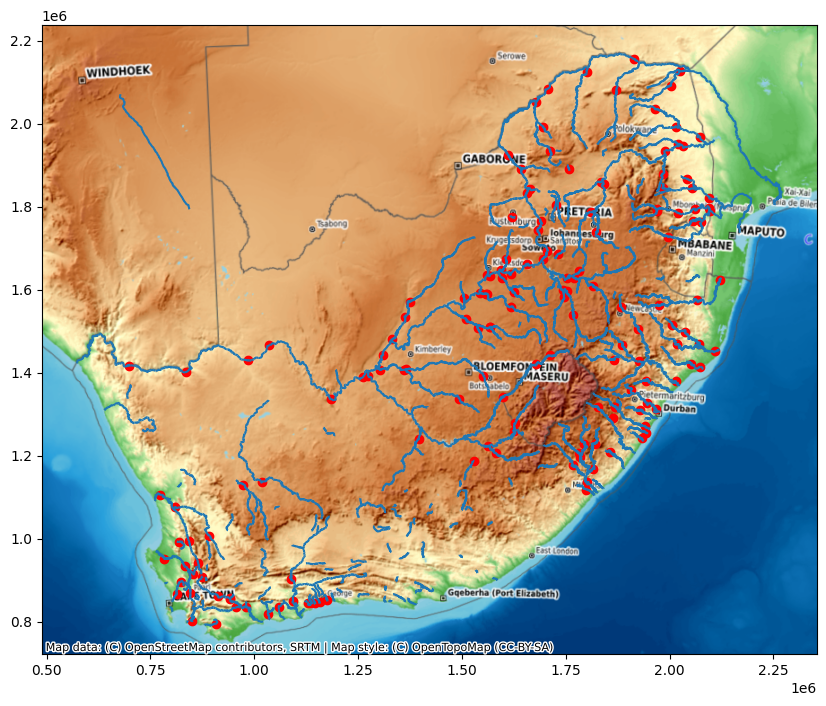

In [28]:
axis = training_df.plot(figsize=(10,10), color = 'red')
rivers_df.plot(ax = axis)
cx.add_basemap(ax=axis, source=cx.providers.OpenTopoMap, crs = training_df.crs)

# Descargar imagenes satelitales Landsat

Los satelites recorren la tierra continuamente, fotografiando la superficie de esta, y midiendo la 'reflectancia', la luz del sol que reflejan los objetos.
A diferencia de las camaras comunes o de nuestros ojos, que capturan la información de la luz en 3 longitudes de onda, correspondiendo a los colores rojo, verde y azul, los satelites contienen camaras e instrumentos especializados que son capaces de capturar imagenes en varias longitudes de onda a la vez, a las que denominaremos bandas.

Cada banda proporciona información especifica, y dependiendo de las aplicaciones se usaran algunas u otras. Además las bandas se pueden combinar en indices especializados para medir ciertas magnitudes de interes, como por ejemplo indice de vegetación.

Más información acerca del uso de cada banda aqui: https://gisgeography.com/spectral-signature/
Más información acerda de las bandas de Landsat: https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites

In [29]:
import pystac_client
import planetary_computer as pc
from odc.stac import stac_load
import rioxarray

Carguemos nuevamente nustros datos, esta vez incluyendo la fecha de muestreo.

In [30]:
training_df = pd.read_csv('water_quality_training_dataset.csv', usecols=['Latitude','Longitude','Sample Date'])
training_df = gpd.GeoDataFrame(training_df, geometry=gpd.points_from_xy(training_df.Longitude, training_df.Latitude), crs='EPSG:4326')

A modo de demostración, usaremos solo una ubicación.

In [31]:
pdf = list(training_df.groupby(['Longitude','Latitude']))[3][1]

In [32]:
pdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 6 entries, 2154 to 8471
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Latitude     6 non-null      float64 
 1   Longitude    6 non-null      float64 
 2   Sample Date  6 non-null      object  
 3   geometry     6 non-null      geometry
dtypes: float64(2), geometry(1), object(1)
memory usage: 240.0+ bytes


Tenemos que convertir las fechas a un formato especializado que los programas entiendan mejor.

In [33]:
pdf['Sample Date'] = pd.to_datetime(pdf['Sample Date'], format='mixed')
pdf['Sample Date'] = pdf['Sample Date'].apply(lambda date: date.tz_localize("UTC"))
pdf

,Latitude,Longitude,Sample Date,geometry
2154,-33.722667,18.616917,2012-10-05 00:00:00+00:00,POINT (18.61692 -33.72267)
2269,-33.722667,18.616917,2012-06-06 00:00:00+00:00,POINT (18.61692 -33.72267)
2375,-33.722667,18.616917,2012-06-26 00:00:00+00:00,POINT (18.61692 -33.72267)
3827,-33.722667,18.616917,2013-04-25 00:00:00+00:00,POINT (18.61692 -33.72267)
8301,-33.722667,18.616917,2015-11-06 00:00:00+00:00,POINT (18.61692 -33.72267)
8471,-33.722667,18.616917,2014-11-06 00:00:00+00:00,POINT (18.61692 -33.72267)


In [34]:
inital_time = min(pdf['Sample Date']) - pd.DateOffset(days=15)
inital_time

Timestamp('2012-05-22 00:00:00+0000', tz='UTC')

In [35]:
final_time = max(pdf['Sample Date']) + pd.DateOffset(days=15)
final_time

Timestamp('2015-11-21 00:00:00+0000', tz='UTC')

Calculamos un area de 1000 metros alrededor del punto de muestreo.

In [36]:
pdf['Buffer'] = pdf.to_crs(epsg=9221).buffer(1000).to_crs(epsg=4326)
bounds = pdf['Buffer'].total_bounds
bounds
#Bounds in order min Longitude, min Latitude, max Longitude, max Latitude

array([ 18.60605155, -33.73160305,  18.6277817 , -33.71373037])

Para acceder a las imagenes, utilizamos la API stac de planetary computer.

In [37]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

In [38]:
search = stac.search(
    bbox=bounds, 
    datetime=[inital_time,final_time],
    collections=['landsat-c2-l2'],
    query={"eo:cloud_cover": {"lt": 1}},
)

In [39]:
items = list(search.items())
print(f'Encontradas {len(items)} imagenes en total')

Encontradas 31 imagenes en total


Descargar las imagenes es bastante lento, por lo que filtramos eligiendo la imagen mas cercana en el tiempo para cada muestra.

In [40]:
new_items = []
for date in pdf['Sample Date']:
    closest_item = min(
        items,
        key=lambda item: abs(item.datetime - date)
    )
    print(closest_item.datetime)
    new_items.append(closest_item)

2013-02-25 08:31:22.086935+00:00
2013-02-25 08:31:22.086935+00:00
2013-02-25 08:31:22.086935+00:00
2013-04-30 08:31:08.179848+00:00
2015-09-19 08:35:11.219048+00:00
2014-10-26 08:33:19.655293+00:00


Para obtener las imagenes, es necesario elegir una resolución de imagen y las bandas deseadas

In [41]:
resolution = 30  # Metros por pixel 
scale = resolution / 111320.0 # Grados por pixel para crs=4326 

In [63]:
data = stac_load(new_items,
bands=["green","red","blue","nir08","swir16","swir22"],
crs="EPSG:4326", # Latitude-Longitude
resolution=scale, # Degrees
dtype="uint16",
patch_url=pc.sign,
bbox=bounds)

Como todo dato geoespacial, las imagenes satelitales vienen con un CRS definido

In [43]:
data.rio.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [44]:
data

<xarray.Dataset> Size: 265kB
Dimensions:      (latitude: 67, longitude: 82, time: 4)
Coordinates:
  * latitude     (latitude) float64 536B -33.71 -33.71 -33.71 ... -33.73 -33.73
  * longitude    (longitude) float64 656B 18.61 18.61 18.61 ... 18.63 18.63
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 32B 2013-02-25T08:31:22.086935 ... 201...
Data variables:
    green        (time, latitude, longitude) uint16 44kB 11920 11692 ... 8758
    red          (time, latitude, longitude) uint16 44kB 13963 13655 ... 8365
    blue         (time, latitude, longitude) uint16 44kB 10426 10217 ... 8041
    nir08        (time, latitude, longitude) uint16 44kB 16693 16693 ... 17362
    swir16       (time, latitude, longitude) uint16 44kB 22513 21549 ... 11774
    swir22       (time, latitude, longitude) uint16 44kB 17493 16781 ... 9527

Las datos en landsat necesitan un preprocesamiento antes de poder interpretarse como reflectancia.
Más información: https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products

In [73]:
scale = 0.0000275 
offset = -0.2 
data = data.astype(float) * scale + offset

Podemos observar las imagenes en color real

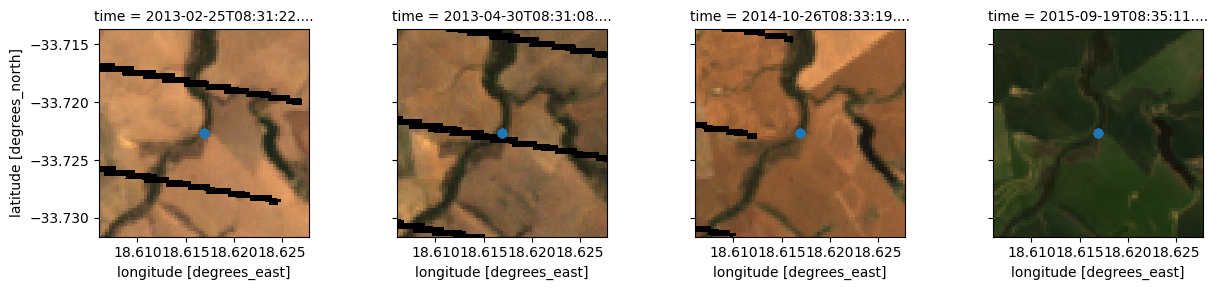

In [74]:
plot_data = data[["red","green","blue"]].to_array()
grid = plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=1000)
axes = grid.axs.flat
for ax in axes:
    pdf.plot(ax = ax)


Si queremos las unidades en metros, podemos reproyectar hacia otro CRS

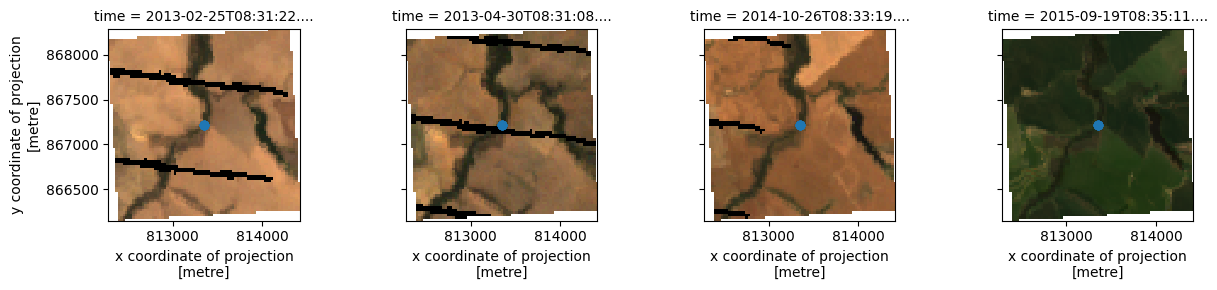

In [49]:
data2 = data.rio.reproject(dst_crs=9221)
plot_data = data2[["red","green","blue"]].to_array()
grid = plot_data.plot.imshow(col='time', col_wrap=4, vmin=0, vmax=500)
axes = grid.axs.flat
for ax in axes:
    pdf.to_crs(epsg=9221).plot(ax = ax)

Para calcular cantidades derivadas, como indices especiales, la sintaxis es similar a pandas

In [50]:
data['ndvi'] = (data.nir08-data.red)/(data.nir08 + data.red)
data['mndwi'] = (data.green-data.swir16)/(data.green + data.swir16)
data['ndmi'] = (data.nir08-data.swir16)/(data.nir08 + data.swir16)

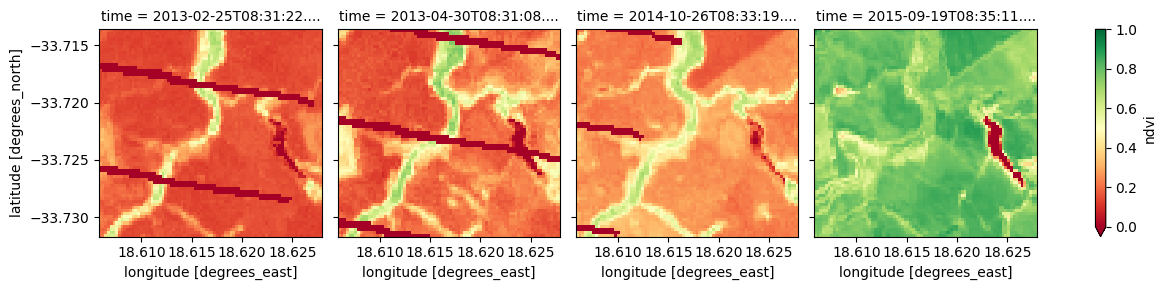

In [51]:
grid = data['ndvi'].plot.imshow(col='time', col_wrap=4, cmap="RdYlGn", vmin=0, vmax=1)

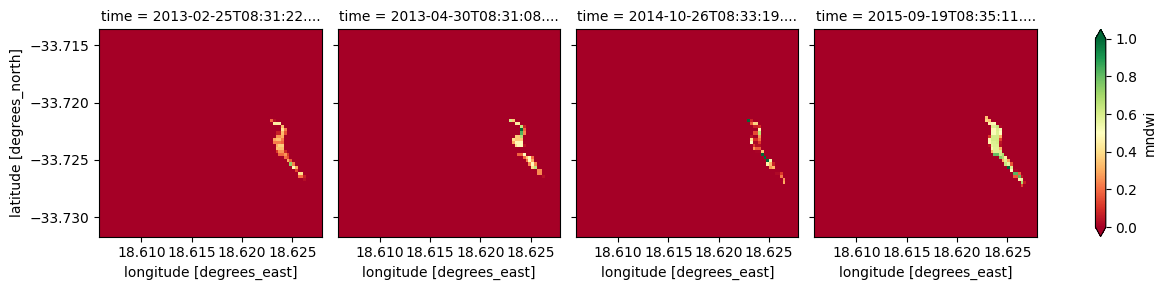

In [52]:
grid = data['mndwi'].plot.imshow(col='time', col_wrap=4, cmap="RdYlGn", vmin=0, vmax=1)

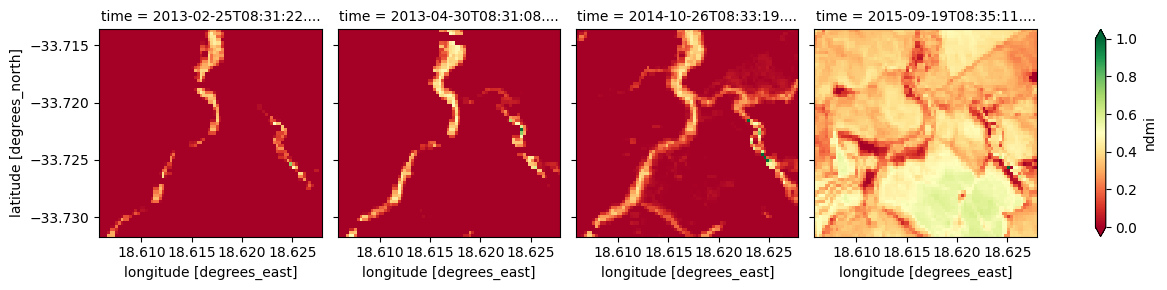

In [53]:
grid = data['ndmi'].plot.imshow(col='time', col_wrap=4, cmap="RdYlGn", vmin=0, vmax=1)

In [54]:
data["green"].median(dim=["latitude","longitude"]).to_pandas()

time
2013-02-25 08:31:22.086935    0.134097
2013-04-30 08:31:08.179848    0.103353
2014-10-26 08:33:19.655293    0.097990
2015-09-19 08:35:11.219048    0.051982
Name: green, dtype: float64

Guardemos la ultima imagen en un archivo GeoTIFF, una imagen TIFF con capacidades espaciales.

In [55]:
save_data = data.isel(time=3)

In [56]:
save_data.rio.to_raster('Mi primera imagen.tiff')

Para cargarla nuevamente usamos rioxarray

In [57]:
import rioxarray as rxr

In [58]:
load_data = rxr.open_rasterio('Mi primera imagen.tiff', band_as_variable=True)

In [59]:
load_data = load_data.rename({'x':'longitude', 'y':'latitude'})
names = {'band_1': 'green', 'band_2': 'red', 'band_3': 'blue',
        'band_4': 'nir08', 'band_5': 'swir16', 'band_6': 'swir22', 'band_7': 'ndvi',
        'band_8': 'mndwi', 'band_9': 'ndmi'}
load_data = load_data.rename_vars(names)

Toda nuestra informacion importante sigue guardada

In [69]:
load_data.rio.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

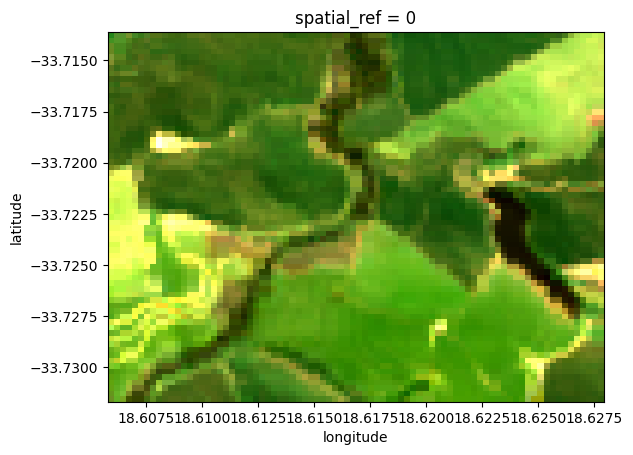

In [70]:
plot_data = load_data[["red","green","blue"]].to_array(dim='band')
plot_data.plot.imshow(robust = True)